In [26]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations

### Data Preprocessing & Augmentation

In [34]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img, padding=5, min_crop_size=(70, 70)):
    """
    Crops the image to the largest contour found using Canny edge detection.
    Returns the original image if no valid contour is found.
    """
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()

    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 300]  # slightly more relaxed

    if contours:
        # Use the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        x_end = min(img.width, x + w + 2 * padding)
        y_end = min(img.height, y + h + 2 * padding)

        cropped = img.crop((x, y, x_end, y_end))
        
        # Only return cropped if it still has valid size
        if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1]:
            return cropped

    return img  # fallback: return original image if crop fails

# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)

# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change

def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img

#function to normalise image
def normalize_image(img_tensor):
            mean = torch.tensor([0.485, 0.456, 0.406], dtype=img_tensor.dtype).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], dtype=img_tensor.dtype).view(3, 1, 1)
            return (img_tensor - mean) / std
# function to denormalise image:
def denormalize_image(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# function to adjust contrast
def adjust_contrast(img, min_factor=1.1, max_factor=1.5, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(factor)
    return img

### Image Loading, Filtering, and Augmentation Strategy

1. Filtering out bad data (blurry or tiny images)
2. Handling class imbalance by downsampling an over-represented class (class 15) & unsampling rare classes with extra augmentation
3. Applying the final augmentation pipeline, resizing, normalizing and converting to tensors for model training

In [35]:
import torch
from collections import Counter
from PIL import Image
import os
import numpy as np

train_folder = "Train"
train_images = []
train_labels = []

# Define rare class threshold and augmentation params
rare_threshold = 150
extra_copies = 2

# Low-quality filtering thresholds
min_file_size_kb = 10
min_resolution = (40, 40)

# First, count class frequencies
all_labels = [int(f.split("__")[0]) for f in os.listdir(train_folder) if f.endswith(".png")]
class_counts = Counter(all_labels)
rare_classes = [cls for cls, count in class_counts.items() if count < rare_threshold]

print(f"Rare classes: {rare_classes}")

# Function to detect low-quality images
def is_low_quality(file_path):
    if os.path.getsize(file_path) < min_file_size_kb * 1024:
        return True
    try:
        img = Image.open(file_path)
        return img.width < min_resolution[0] or img.height < min_resolution[1]
    except:
        return True
    return False

for img_file in os.listdir(train_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(train_folder, img_file)

    # Skip low-quality images
    if is_low_quality(img_path):
        print(f"Skipping low-quality: {img_file}")
        continue

    class_label = int(img_file.split("__")[0])

    # ⚠️ Downsample class 15 (keep ~65% of its images)
    if class_label == 15 and random.random() > 0.65:
        continue
    
    img = Image.open(img_path).convert("RGB")
    img = auto_crop(img)

    def process_and_store(img_obj):
        img_aug = img_obj.copy()

        # Apply augmentations
        if class_label in rare_classes:
            img_aug = adjust_contrast(img_aug, min_factor=1.2, max_factor=1.6, prob=0.9)
            img_aug = adjust_saturation(img_aug, min_factor=0.95, max_factor=1.1, prob=0.4)
            img_aug = rotate_image(img_aug, max_angle=10, rotation_prob=0.5)
            img_aug = add_random_noise(img_aug, prob=0.2)
            img_aug = apply_random_blur(img_aug, prob=0.2)

        else:
            img_aug = rotate_image(img_aug, max_angle=7, rotation_prob=0.3)
            img_aug = adjust_contrast(img_aug, min_factor=1.0, max_factor=1.2, prob=0.3)
            img_aug = adjust_saturation(img_aug, min_factor=0.95, max_factor=1.1, prob=0.3)
            img_aug = add_random_noise(img_aug, prob=0.1)
            img_aug = apply_random_blur(img_aug, prob=0.1)

        # Resize, normalize, and store
        img_aug = resize_image(img_aug, target_size)
        img_aug = np.array(img_aug) / 255.0
        img_aug = torch.tensor(img_aug, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        # Brightness check BEFORE normalization
        if torch.mean(img_aug) < 0.05:
            return  # Skip too-dark image       
        
        img_aug = normalize_image(img_aug)
        train_images.append(img_aug)
        train_labels.append(class_label)

    # Store original image
    process_and_store(img)

    # Add more versions if rare class
    if class_label in rare_classes:
        for _ in range(extra_copies):
            process_and_store(img)

# Convert to arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)

Rare classes: [11, 18, 9, 7, 23, 14, 20, 12, 1, 5, 10, 3, 13, 19]
Skipping low-quality: 21__4088.png
Skipping low-quality: 0__1102 2.png
Skipping low-quality: 21__1994 2.png
Skipping low-quality: 8__1339.png
Skipping low-quality: 2__112.png
Skipping low-quality: 7__3368.png
Skipping low-quality: 0__29 2.png
Skipping low-quality: 21__2002.png
Skipping low-quality: 4__2321.png
Skipping low-quality: 0__30 2.png
Skipping low-quality: 21__2003.png
Skipping low-quality: 0__2114 2.png
Skipping low-quality: 8__1337 2.png
Skipping low-quality: 11__3515.png
Skipping low-quality: 8__1338.png
Skipping low-quality: 7__3382.png
Skipping low-quality: 21__4089.png
Skipping low-quality: 4__2280.png
Skipping low-quality: 21__4048.png
Skipping low-quality: 22__3075.png
Skipping low-quality: 4__1206.png
Skipping low-quality: 21__2001.png
Skipping low-quality: 0__1098 2.png
Skipping low-quality: 21__1938.png
Skipping low-quality: 21__2000.png
Skipping low-quality: 10__1410.png
Skipping low-quality: 4__2280

### Class Distribution Visualisaton after Augmentation

1. Count how many images are in each class
2. Visualise the distribution using a bar graph 

Class 0: 161 samples
Class 1: 252 samples
Class 2: 279 samples
Class 3: 288 samples
Class 4: 191 samples
Class 5: 249 samples
Class 6: 159 samples
Class 7: 216 samples
Class 8: 106 samples
Class 9: 315 samples
Class 10: 387 samples
Class 11: 378 samples
Class 12: 411 samples
Class 13: 330 samples
Class 14: 417 samples
Class 15: 297 samples
Class 16: 169 samples
Class 17: 172 samples
Class 18: 183 samples
Class 19: 249 samples
Class 20: 180 samples
Class 21: 296 samples
Class 22: 174 samples
Class 23: 348 samples


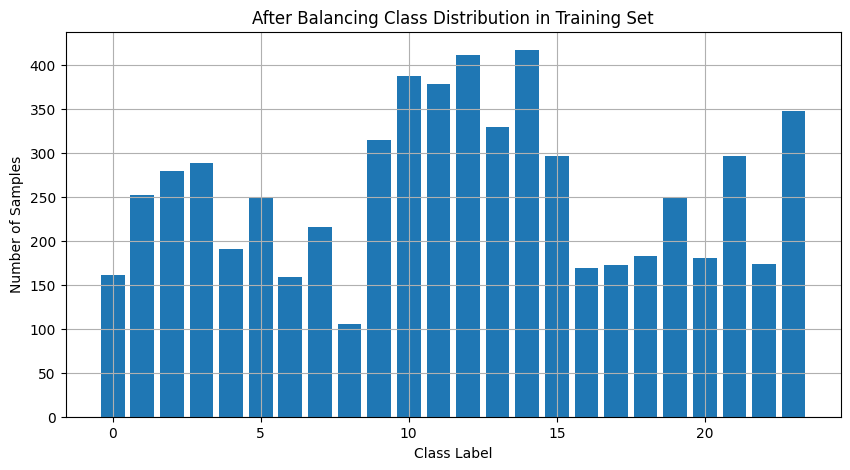

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique_classes, class_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples") # Print each class and respective samples

# Plotting the distribution of the classes
plt.figure(figsize=(10, 5))
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("After Balancing Class Distribution in Training Set")
plt.grid(True)
plt.show()


### Visual Inspection of Preprocessed Training Images

1. Randomly selecting a few preprocessed images from out training data
2. Denormalizing them 
3. Displaying them with their class labels to visually verify that: images still look like they should, augmentations didn't distort them too much & labels still make sense

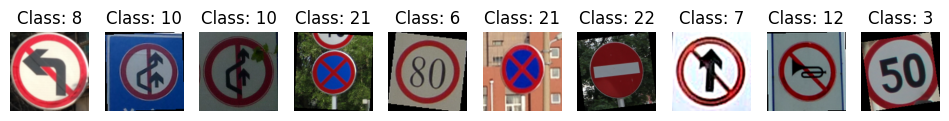

In [37]:
num_samples = 10 # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)
#random_indices = np.size(random.sample(range(len(X_train)), 1))
#print(random_indices)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    img_tensor = torch.tensor(X_train[idx])                 # Convert to tensor
    img = denormalize_image(img_tensor)                     # Undo normalization
    img = img.permute(1, 2, 0).numpy().clip(0, 1)            # [C, H, W] → [H, W, C]

    plt.imshow(img)    
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


### Preprocessing the Test Set & Final Test Dataset Validation

1. Take images from the test folder and applying minimal preprocessing to ensure consistency with the training set but without augmenting anything
2. After preprocessing all test images, we print out some basic info to confirm the shape of X_test, y_test and the number of unique classes in the training set
3. This is a quick check to make sure our label encoding and class mapping are correct

In [39]:
test_folder = "Test"  # Replace with actual test folder name
test_images = []
test_labels = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(test_folder, img_file)
        img = Image.open(img_path).convert("RGB")

        class_label = int(img_file.split("__")[0])

        # Preprocessing: only clean, no augmentation
        img = auto_crop(img)  # Optional but keeps it consistent
        img = resize_image(img, target_size)
        
        img = np.array(img) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        img = normalize_image(img) # Normalize to [0, 1]

        test_images.append(img)
        test_labels.append(class_label)

X_test = np.array(test_images)
y_test = np.array(test_labels)

print(np.shape(X_test))
print(np.shape(y_test))
print(len(np.unique(y_train)))

(2583, 3, 224, 224)
(2583,)
24


### Visual Inspection of Test Images

Randomly select 10 test images and displaying them with their class lavels so it helps us visually verify the quality and correctness of the test preprocessing pipeline, just like we did for training data

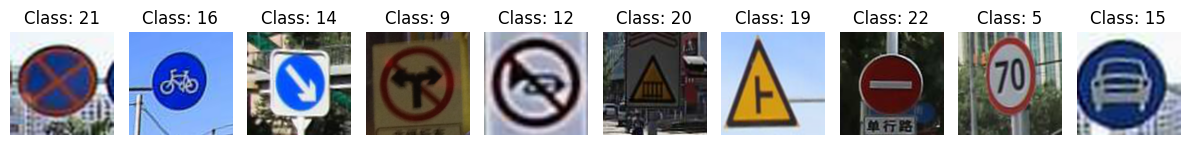

In [40]:
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)

    img_tensor = torch.tensor(X_test[idx])                 # Convert NumPy to torch
    img = denormalize_image(img_tensor)                    # Undo normalization
    img = img.permute(1, 2, 0).numpy().clip(0, 1)           # [C, H, W] → [H, W, C]

    plt.imshow(img)
    plt.title(f"Class: {y_test[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



# CNN Modeling

## Dataset Preparation for Training and Validation

1. Convert all our cleaned image data to PyTorch tensors. 
2. Split out training data into training and validation sets (80/20)
3. Package everything into PyTorch Dataset and DataLoader objects, which help us train efficiently in batches.

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

# Defining device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use GPU if available

# Convert preprocessed lists to tensors
X_all = torch.stack(train_images)
y_all = torch.tensor(y_train, dtype=torch.long)

# Split into training and validation (80% / 20%)
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Also prepare the test set
X_test_tensor = torch.stack(test_images)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## CNN Model (Minimal layers)

We’re defining a custom CNN model using PyTorch. This model takes in preprocessed images and learns to predict which class they belong to 

In [43]:
input_size = 224*224
output_size = len(np.unique(y_train)) #number of classes=24

class CNN(nn.Module):
    def __init__(self, output_size=24):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)       # (3, 224, 224) -> (6, 220, 220)
        self.bn1 = nn.BatchNorm2d(6)                      # BatchNorm after first conv
        self.pool = nn.MaxPool2d(2, 2)                    # (6, 220, 220) -> (6, 110, 110)
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)      # (6, 110, 110) -> (16, 106, 106)
        self.bn2 = nn.BatchNorm2d(16)                     # (16, 106, 106)
        self.dropout2 = nn.Dropout2d(0.2)   

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout2d(0.15)      

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 26 * 26, 120)
        self.dropout_fc1 = nn.Dropout(0.3)                # Dropout after fc1
        self.fc2 = nn.Linear(120, 84)
        self.dropout_fc2 = nn.Dropout(0.5)                    # Dropout before final layer
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        x = self.fc3(x)
        return x




## Model Variables 

1. How fast the model learns
2. How long it trains
3. How complex the feature extraction starts off

In [44]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
n_features = 32 #32 convolutional filters in first conv layer 
learning_rate = 0.0001 #reduced learning rate for more stable training
num_epochs = 20

### Model Initialization & Training Configuration

1. Initializing our CNN model and moving it to the right device (CPU/GPU),
2. Defining the loss function to evaluate model performance
3. Choosing the optimizer to update the model's weights

In [45]:
# Initialising the CNN model 
model = CNN(output_size=24)
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight


criterion = nn.CrossEntropyLoss()


# Set optimizer with optimizer (can change) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0005)  #used Adam optimiser instead: converges faster and better for classification tasks


## Model Training & Validation Loop 

1. Training the CNN over multiple epochs
2. Tracking training and validation losses and accuracies
3. Using .train() and .eval() modes properly
4. Printing progress at the end of each epoch

In [46]:
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # 🔍 Validation evaluation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] - Train Loss: 2.9314 - Train Acc: 14.30% - Val Loss: 2.4220 - Val Acc: 37.36%
Epoch [2/20] - Train Loss: 2.4507 - Train Acc: 28.26% - Val Loss: 1.8422 - Val Acc: 62.64%
Epoch [3/20] - Train Loss: 2.0228 - Train Acc: 41.91% - Val Loss: 1.3944 - Val Acc: 74.64%
Epoch [4/20] - Train Loss: 1.6479 - Train Acc: 53.23% - Val Loss: 1.0377 - Val Acc: 78.82%
Epoch [5/20] - Train Loss: 1.3394 - Train Acc: 61.67% - Val Loss: 0.7885 - Val Acc: 82.93%
Epoch [6/20] - Train Loss: 1.1394 - Train Acc: 68.00% - Val Loss: 0.6135 - Val Acc: 86.23%
Epoch [7/20] - Train Loss: 0.9767 - Train Acc: 71.74% - Val Loss: 0.4872 - Val Acc: 88.97%
Epoch [8/20] - Train Loss: 0.8409 - Train Acc: 75.65% - Val Loss: 0.3997 - Val Acc: 91.14%
Epoch [9/20] - Train Loss: 0.7354 - Train Acc: 78.45% - Val Loss: 0.3203 - Val Acc: 94.04%
Epoch [10/20] - Train Loss: 0.6539 - Train Acc: 81.37% - Val Loss: 0.2536 - Val Acc: 95.65%
Epoch [11/20] - Train Loss: 0.5711 - Train Acc: 82.64% - Val Loss: 0.2235 - Val Acc: 95.9

## Training & Validation Curve Visualisation

1. Loss vs Epochs (to see how well the model is minimizing error)
2. Accuracy vs Epochs (to see how well the model is improving prediction over time)

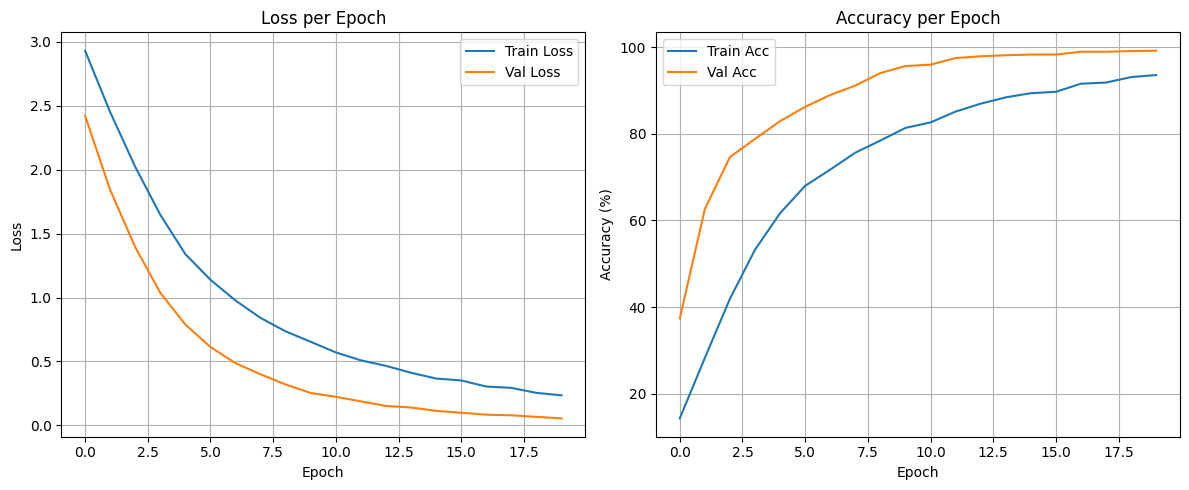

In [47]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Testing 

### Model Evaluation: Confusion Matrix

1. Evaluate the model on the test set (unseen during training)
2. Calculate:
- Loss and accuracy on the test data,
- A confusion matrix to visualize prediction correctness across classes,
- A classification report to get precision, recall, and F1 scores for each class.


Test Loss: 0.8966
Test Accuracy: 73.33%


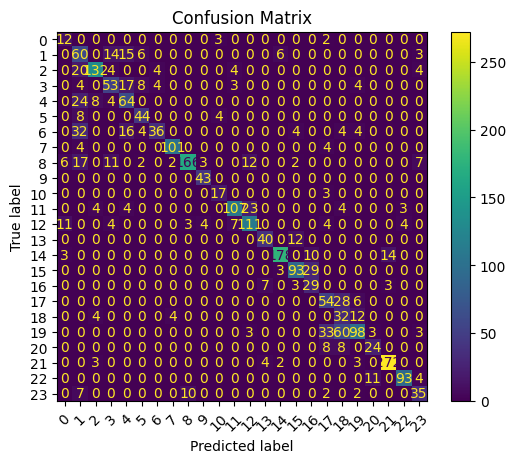

              precision    recall  f1-score   support

           0      0.375     0.706     0.490        17
           1      0.341     0.577     0.429       104
           2      0.874     0.786     0.828       168
           3      0.589     0.570     0.579        93
           4      0.552     0.640     0.593       100
           5      0.688     0.786     0.733        56
           6      0.818     0.360     0.500       100
           7      0.944     0.927     0.935       109
           8      0.927     0.728     0.816       228
           9      0.860     1.000     0.925        43
          10      0.708     0.850     0.773        20
          11      0.884     0.738     0.805       145
          12      0.745     0.750     0.747       148
          13      0.784     0.769     0.777        52
          14      0.942     0.868     0.904       205
          15      0.816     0.744     0.778       125
          16      0.426     0.690     0.527        42
          17      0.491    

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))


## ResNet18 CNN Model 



We’re using a pretrained ResNet-18 model from torchvision. Originally trained on ImageNet (a massive dataset) & fine-tuning it for our 24-class classification problem

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn import Linear 
from torchvision.models import resnet18, ResNet18_Weights


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


num_classes = len(torch.unique(y_train_tensor))
# Load pretrained ResNet and modify the last layer
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_model.fc = Linear(in_features= 512, out_features = 24) # Adjust output layer
model = resnet_model.to(device)

# Variables for our model
learning_rate = 0.0001 #reduced learning rate for more stable training
num_epochs = 20

## Loss Function & Optimizer for Transfer Learning

1. Loss function: CrossEntropyLoss() is used again (same as before)
2. Optimizer: this time using SGD with momentum instead of Adam

In [64]:

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

## Model Summary & Architecture Overview

Moves the model temporarily to CPU to work with torchsummary (which doesn’t always play well with GPU).
Passes a dummy input of shape (3, 224, 224), the size of our RGB images.
Prints a detailed summary of each layer in the model:
- Layer types and output shapes
- Number of learnable parameters
- Total params / trainable params
- Layer-by-layer structure

In [68]:
print(summary(model.to("cpu"), input_size=(3, 224, 224), device="cpu"))
model = model.to(device)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Fine-Tuning the Pretrained Resnet-18 Model

This training loop fine-tunes the pretrained ResNet-18 on your custom dataset by:
- Training the model with batches of data,
- Tracking performance via loss and accuracy,
- Evaluating the model on a validation set after each epoch,
- Storing the results for visualization later.

In [69]:
# TRAINING 
val_accuracies = []
val_losses = []
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] - Train Loss: 3.1032 - Train Acc: 12.21% - Val Loss: 2.7400 - Val Acc: 25.68%
Epoch [2/20] - Train Loss: 2.4426 - Train Acc: 41.33% - Val Loss: 2.1747 - Val Acc: 54.43%
Epoch [3/20] - Train Loss: 1.9401 - Train Acc: 62.34% - Val Loss: 1.7258 - Val Acc: 70.37%
Epoch [4/20] - Train Loss: 1.5577 - Train Acc: 74.28% - Val Loss: 1.3828 - Val Acc: 77.38%
Epoch [5/20] - Train Loss: 1.2670 - Train Acc: 81.17% - Val Loss: 1.1407 - Val Acc: 81.56%
Epoch [6/20] - Train Loss: 1.0532 - Train Acc: 85.28% - Val Loss: 0.9487 - Val Acc: 85.51%
Epoch [7/20] - Train Loss: 0.8842 - Train Acc: 88.26% - Val Loss: 0.8084 - Val Acc: 87.60%
Epoch [8/20] - Train Loss: 0.7579 - Train Acc: 90.88% - Val Loss: 0.6930 - Val Acc: 90.42%
Epoch [9/20] - Train Loss: 0.6495 - Train Acc: 92.99% - Val Loss: 0.5994 - Val Acc: 92.03%
Epoch [10/20] - Train Loss: 0.5614 - Train Acc: 94.28% - Val Loss: 0.5228 - Val Acc: 93.16%
Epoch [11/20] - Train Loss: 0.4920 - Train Acc: 95.49% - Val Loss: 0.4601 - Val Acc: 94.7

## ResNet-18 Training & Validation Curves

1. Training loss vs Validation loss
2. Training accuracy vs Validation accuracy

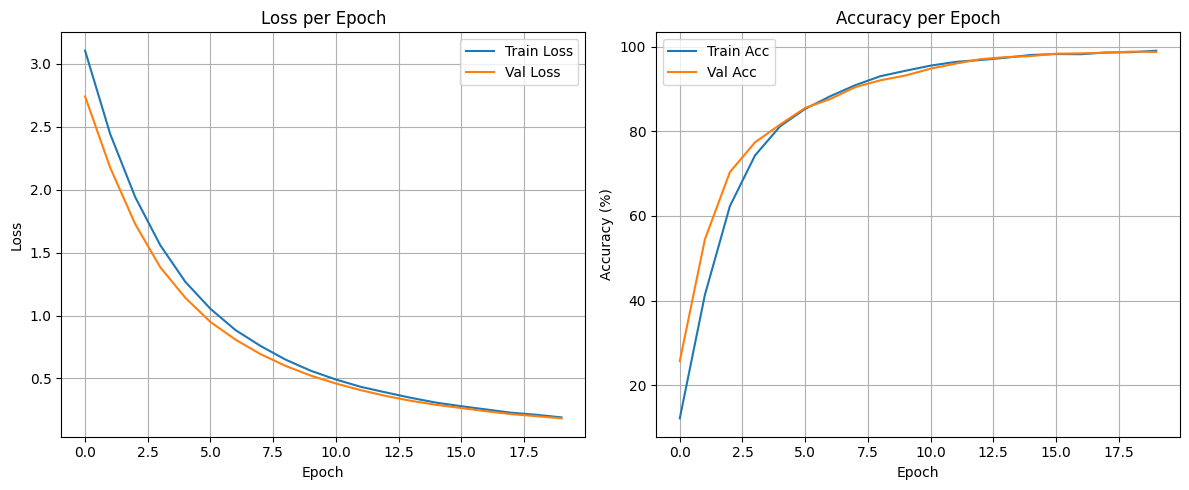

In [70]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## ResNet-18 Test Evaluation

- Calculating loss & accuracy
- Generating a confusion matrix
- Printing a classification report with precision, recall, & F1-score


Test Loss: 0.8589
Test Accuracy: 81.49%


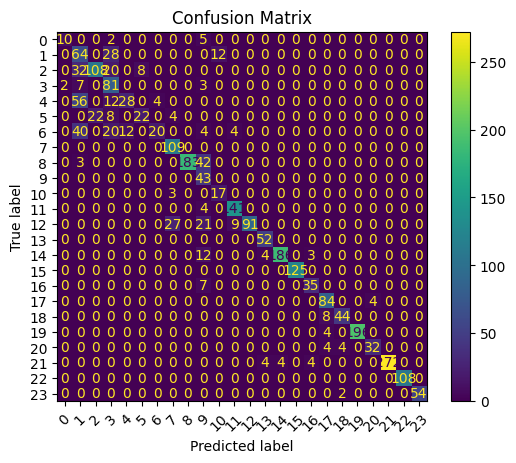

              precision    recall  f1-score   support

           0      0.833     0.588     0.690        17
           1      0.317     0.615     0.418       104
           2      0.831     0.643     0.725       168
           3      0.474     0.871     0.614        93
           4      0.700     0.280     0.400       100
           5      0.733     0.393     0.512        56
           6      0.833     0.200     0.323       100
           7      0.762     1.000     0.865       109
           8      1.000     0.803     0.891       228
           9      0.305     1.000     0.467        43
          10      0.586     0.850     0.694        20
          11      0.916     0.972     0.943       145
          12      1.000     0.615     0.762       148
          13      0.867     1.000     0.929        52
          14      0.979     0.907     0.942       205
          15      1.000     1.000     1.000       125
          16      0.833     0.833     0.833        42
          17      0.840    

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))

## VGG16 CNN Pre-trained Model

- Calculating average test loss & test accuracy
- Generating a confusion matrix to visualize prediction quality across classes
- Printing a classification report that includes precision, recall, & F1-score for each class

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.nn import Linear
from torchvision.models import vgg16, VGG16_Weights

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_classes = len(torch.unique(y_train_tensor))

# Load the pretrained VGG16 model (pretrained on imagenet)
vgg16_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Modified the final fully connected layer (classifier) with our classes
vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

for param in vgg16_model.features.parameters():
    param.requires_grad = True

# Move the model to the configured device (GPU/CPU)
vgg16_model = vgg16_model.to(device)

learning_rate = 0.001

# Check the model architecture byb temporarily moving to CPU for summary
summary(vgg16_model.to("cpu"), (3, 224, 224), device="cpu") 

# Move back to device (MPS or CPU)
vgg16_model = vgg16_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## VGG16 Training Configuration

We're configuring:
- The loss function that tells the model how wrong it is
- The optimizer that updates the model's weights based on the gradients from backpropagation

In [78]:

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

## VGG16 Model Training Loop

Training the VGG16 model over multiple epochs using:
- Mini-batch gradient descent
- SGD optimizer with momentum and weight decay
- Cross-entropy loss for a multi-class classification task

We're also tracking:
- Average training loss per epoch
- Training accuracy per epoch

In [79]:
train_losses = []
train_accuracies = []
val_losses = []            # Add validation tracking
val_accuracies = []

for epoch in range(num_epochs):
    vgg16_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:  
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # VALIDATION PHASE
    vgg16_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = vgg16_model(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] - Train Loss: 1.2778 - Train Acc: 62.18% - Val Loss: 0.0993 - Val Acc: 96.70%
Epoch [2/20] - Train Loss: 0.0638 - Train Acc: 98.15% - Val Loss: 0.0224 - Val Acc: 99.52%
Epoch [3/20] - Train Loss: 0.0105 - Train Acc: 99.82% - Val Loss: 0.0126 - Val Acc: 99.76%
Epoch [4/20] - Train Loss: 0.0086 - Train Acc: 99.82% - Val Loss: 0.0110 - Val Acc: 99.76%
Epoch [5/20] - Train Loss: 0.0051 - Train Acc: 99.90% - Val Loss: 0.0091 - Val Acc: 99.84%
Epoch [6/20] - Train Loss: 0.0025 - Train Acc: 99.94% - Val Loss: 0.0074 - Val Acc: 99.84%
Epoch [7/20] - Train Loss: 0.0029 - Train Acc: 99.92% - Val Loss: 0.0026 - Val Acc: 99.92%
Epoch [8/20] - Train Loss: 0.0027 - Train Acc: 99.94% - Val Loss: 0.0019 - Val Acc: 100.00%
Epoch [9/20] - Train Loss: 0.0012 - Train Acc: 100.00% - Val Loss: 0.0028 - Val Acc: 99.92%
Epoch [10/20] - Train Loss: 0.0014 - Train Acc: 99.98% - Val Loss: 0.0020 - Val Acc: 100.00%
Epoch [11/20] - Train Loss: 0.0018 - Train Acc: 99.98% - Val Loss: 0.0020 - Val Acc: 9

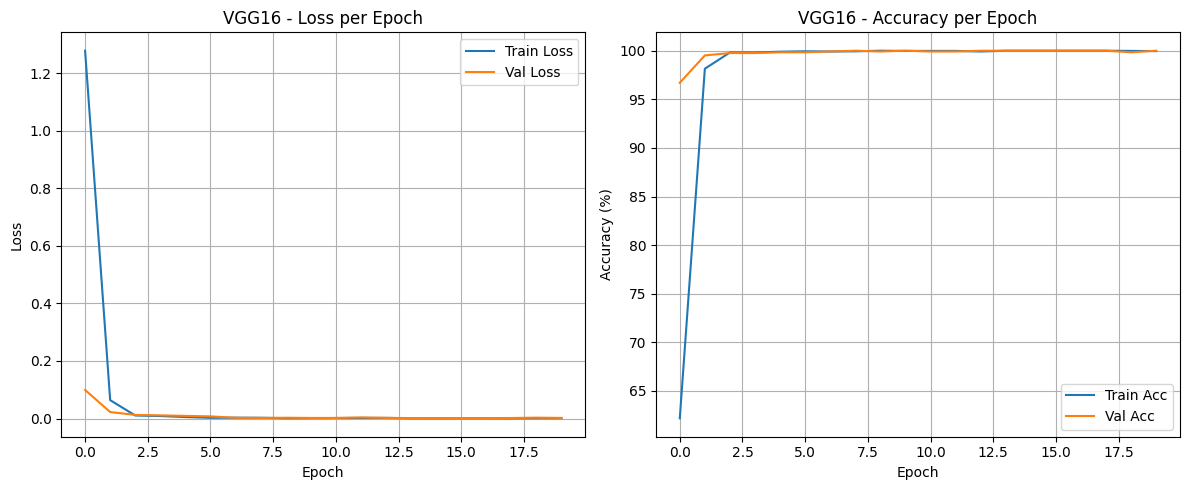

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 📉 Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("VGG16 - Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("VGG16 - Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VGG16 Test Evaluation

Performing final evaluation on the unseen test set after training VGG16 model. This helps us to measure how well the model generalizes beyond training and validation.
We computed:
- Test loss
- Test accuracy
- Confusion Matrix
- Classification report (precision, recall, F1-score)


Test Loss: 0.2418
Test Accuracy: 92.10%


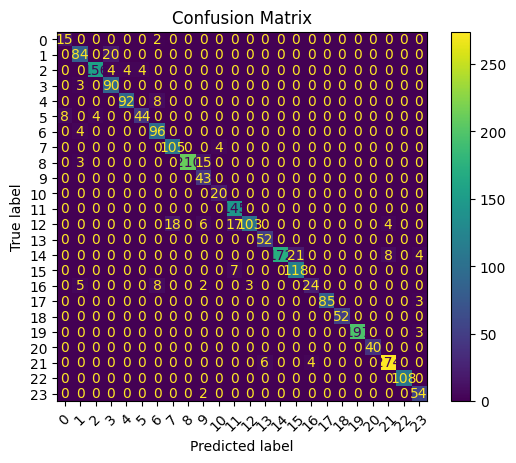

              precision    recall  f1-score   support

           0      0.652     0.882     0.750        17
           1      0.848     0.808     0.828       104
           2      0.975     0.929     0.951       168
           3      0.789     0.968     0.870        93
           4      0.958     0.920     0.939       100
           5      0.917     0.786     0.846        56
           6      0.842     0.960     0.897       100
           7      0.854     0.963     0.905       109
           8      1.000     0.921     0.959       228
           9      0.632     1.000     0.775        43
          10      0.833     1.000     0.909        20
          11      0.858     1.000     0.924       145
          12      0.972     0.696     0.811       148
          13      0.897     1.000     0.945        52
          14      1.000     0.839     0.912       205
          15      0.849     0.944     0.894       125
          16      0.857     0.571     0.686        42
          17      1.000    

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

vgg16_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))